# TOC
* [Dataset filtering](#Dataset-filtering)
* [Augmented stereo analysis](#Augmented-stereo-analysis)
* [Automatic parameter selection](#Automatic-parameter-selection)

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from os.path import join
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

In [2]:
def read_chord_scores_and_confidences(basedir, list_name, hmm_self_prob):
    chord_score = pd.read_csv(join(basedir, 'HMMChords-decode_with_PPD-{}Ps'.format(round(hmm_self_prob,3)), list_name+'-ResultsMirex.csv'), skiprows=2, usecols=[0,1,2], names=['File', 'MAP score', 'Duration'])
    opc_confidences = pd.read_csv(join(basedir, 'HMMChords-decodeMAP_with_medianOPC-{}Ps'.format(round(hmm_self_prob,3)), list_name+'-logprobs_confidences.csv'), header=None, names=['Median OPC confidence'], usecols=[1], squeeze=True)
    ppd_confidences = pd.read_csv(join(basedir, 'HMMChords-decode_with_PPD-{}Ps'.format(round(hmm_self_prob,3)), list_name+'-logprobs_confidences.csv'), header=None, names=['PPD confidence'], usecols=[1], squeeze=True)
    return pd.concat([chord_score, opc_confidences, ppd_confidences], axis=1)

# Dataset filtering

#### Read output

In [3]:
clp_isophonics = read_chord_scores_and_confidences('Experiments/CLPChroma/Isophonics', 'IsophonicsChords2010', 0.1)
deep_isophonics = read_chord_scores_and_confidences('Experiments/DeepChroma/Isophonics', 'IsophonicsChords2010', 0.1)
clp_rwcpop = read_chord_scores_and_confidences('Experiments/CLPChroma/RWC-Popular', 'RWC-Popular', 0.1)
deep_rwcpop = read_chord_scores_and_confidences('Experiments/DeepChroma/RWC-Popular', 'RWC-Popular', 0.1)

In [4]:
clp_isophonics.describe()

,MAP score,Duration,Median OPC confidence,PPD confidence
count,217.000000,217.000000,217.000000,217.000000
mean,57.672850,164.876720,-2.790956,0.498354
std,17.832665,56.721547,0.074882,0.129221
min,0.003509,20.206598,-2.943841,0.079245
25%,48.366617,129.509298,-2.843624,0.413834
50%,59.663311,155.173152,-2.800392,0.496465
75%,70.576815,186.107000,-2.750589,0.587745
max,96.815365,462.400701,-2.558910,0.854183


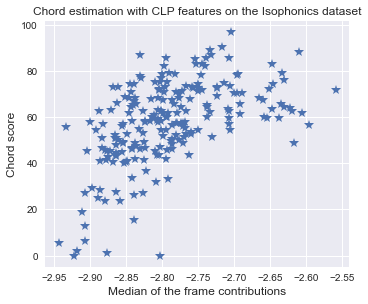

In [5]:
plt.figure(figsize=(5, 4))
plt.plot(clp_isophonics['Median OPC confidence'], clp_isophonics['MAP score'], linestyle='None', marker='*', markersize=10)
plt.tight_layout()
plt.xlabel('Median of the frame contributions', fontsize=12)
#plt.xlabel(r'$\log\left( {p\left(\hat{y}^{1:T}\right)}^{\frac{1}{T} \right)$')
plt.ylabel('Chord score', fontsize=12)
plt.title('Chord estimation with CLP features on the Isophonics dataset')

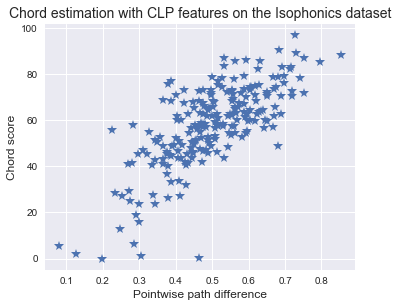

In [6]:
plt.figure(figsize=(5, 4))
plt.plot(clp_isophonics['PPD confidence'], clp_isophonics['MAP score'], linestyle='None', marker='*', markersize=10)
plt.tight_layout()
plt.xlabel('Pointwise path difference', fontsize=12)
plt.ylabel('Chord score', fontsize=12)
plt.title('Chord estimation with CLP features on the Isophonics dataset', fontsize=14)

In [7]:
def weighted_average(dataframe, value_column, weights_column):
    return sum(dataframe[value_column] * dataframe[weights_column]) / sum(dataframe[weights_column])

def confidence_filter(data, confidence_measure, score_measure, num_cutoffs=50):
    cutoffs = np.linspace(np.min(data[confidence_measure]), np.max(data[confidence_measure]), num=num_cutoffs)
    filtered_scores = []
    counts = []
    for cutoff in cutoffs:
        filtered = data[data[confidence_measure] >= cutoff]
        filtered_weighted_average = weighted_average(filtered, score_measure, 'Duration')
        filtered_scores.append(filtered_weighted_average)
        counts.append(len(filtered))
    return cutoffs, counts, filtered_scores

def apply_confidence_filter(results):
    confidence_measures = ['Median OPC confidence', 'PPD confidence']
    score_measure = 'MAP score'
    cutoffs = []
    counts = []
    scores = []
    for result in results:
        for conf in confidence_measures:
            filter_cutoffs, filtered_counts, filtered_scores = confidence_filter(result, conf, score_measure)
            cutoffs.append(filter_cutoffs)
            counts.append(filtered_counts)
            scores.append(filtered_scores)
    return cutoffs, counts, scores

def plot_confidence_filter(filtered_results, dataset_name):
    cutoffs, counts, scores = filtered_results
    fig, ax1 = plt.subplots(1, 1, figsize=(8.4, 4.5))
    ax2 = ax1.twinx()
    for i in range(len(cutoffs)):
        ax1.plot(np.linspace(0, 1, num=len(scores[i])), scores[i], ls="--", marker='o', markersize=10)
        ax1.set_ylabel('Chord score', fontsize=12)
        ax1.set_xlabel('Relative confidence cutoff', fontsize=12)
        ax2.plot(np.linspace(0, 1, num=len(counts[i])), counts[i])
        ax2.set_ylabel('Filtered dataset size', fontsize=12)
    plt.legend(['CLP Median', 'CLP PPD', 'DeepChroma Median', 'DeepChroma PPD'], bbox_to_anchor=(0., -0.2, 1., .102), loc='upper left',
               ncol=4, mode="expand", borderaxespad=0., fontsize=12)
    plt.tight_layout()
    plt.title('Confidence measure filtering on the {} dataset'.format(dataset_name), fontsize=14)

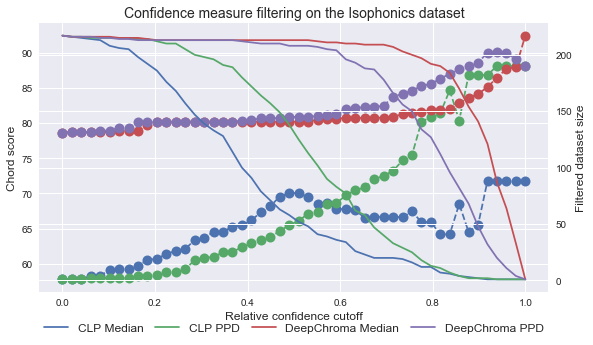

In [8]:
plot_confidence_filter(apply_confidence_filter([clp_isophonics, deep_isophonics]), 'Isophonics')

In [9]:
cutoffs, counts, scores = apply_confidence_filter([clp_isophonics, deep_isophonics])
pd.DataFrame({'cutoffs': np.linspace(0, 1, num=50), 'counts-clp-median': counts[0], 'counts-clp-ppd': counts[1], 'counts-deep-median': counts[2], 'counts-deep-ppd': counts[3], 'scores-clp-median': scores[0], 'scores-clp-ppd': scores[1], 'scores-deep-median': scores[2], 'scores-deep-ppd': scores[3]}).to_csv('isophonics.csv', index=False)

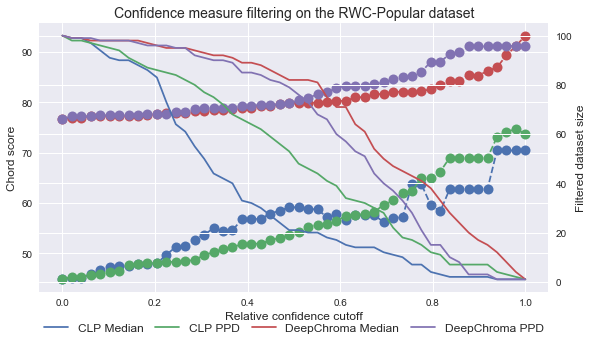

In [10]:
plot_confidence_filter(apply_confidence_filter([clp_rwcpop, deep_rwcpop]), 'RWC-Popular')

In [11]:
cutoffs, counts, scores = apply_confidence_filter([clp_rwcpop, deep_rwcpop])
pd.DataFrame({'cutoffs': np.linspace(0, 1, num=50), 'counts-clp-median': counts[0], 'counts-clp-ppd': counts[1], 'counts-deep-median': counts[2], 'counts-deep-ppd': counts[3], 'scores-clp-median': scores[0], 'scores-clp-ppd': scores[1], 'scores-deep-median': scores[2], 'scores-deep-ppd': scores[3]}).to_csv('rwc-popular.csv', index=False)

## Augmented stereo analysis

In [12]:
clp_isophonics_augmented = read_chord_scores_and_confidences('Experiments/CLPChroma/IsophonicsAugmented', 'IsophonicsChords2010-augmentedstereo', 0.1)
deep_isophonics_augmented = read_chord_scores_and_confidences('Experiments/DeepChroma/IsophonicsAugmented', 'IsophonicsChords2010-augmentedstereo', 0.1)

In [13]:
import os.path
def split_channels(stereo_data):
    stereo_data['File'], stereo_data['Channel']  = zip(*stereo_data['File'].map(os.path.split))
    return stereo_data

def per_channel_score(data):
    stereo_data = split_channels(data)

In [14]:
stereo_data = split_channels(clp_isophonics_augmented)
stereo_data.head()

,File,MAP score,Duration,Median OPC confidence,PPD confidence,Channel
0,The Beatles/01_-_Please_Please_Me/01_-_I_Saw_H...,66.096646,175.804082,-2.863213,0.477544,mono
1,The Beatles/01_-_Please_Please_Me/01_-_I_Saw_H...,66.096646,175.804082,-2.862874,0.478113,left
2,The Beatles/01_-_Please_Please_Me/01_-_I_Saw_H...,66.096646,175.804082,-2.863544,0.477544,right
3,The Beatles/01_-_Please_Please_Me/01_-_I_Saw_H...,78.870873,175.804082,-2.705947,0.538943,hard_left
4,The Beatles/01_-_Please_Please_Me/01_-_I_Saw_H...,66.096646,175.804082,-2.862850,0.478113,centre


In [15]:
channels = ['mono', 'left', 'right', 'hard_left', 'centre', 'hard_right', 'sides']
confidence_measure = 'Median OPC confidence'#'PPD confidence'
score = 'MAP score'
files = set(stereo_data.File.tolist())
per_channel_table = pd.DataFrame(index=files).sort_index()
per_channel_table['Duration'] = stereo_data[stereo_data.Channel == 'mono'][['File', 'Duration']].set_index('File')
for c in channels:
    per_channel_table[score + ' ' + c] = stereo_data[stereo_data.Channel == c][['File', score]].set_index('File')
    per_channel_table[confidence_measure + ' ' + c] = stereo_data[stereo_data.Channel == c][['File', confidence_measure]].set_index('File')

In [16]:
import itertools
all_scores = map(' '.join, itertools.product([score], channels))
all_confidence = map(' '.join, itertools.product([confidence_measure], channels))
per_channel_table['Oracle best score'] = per_channel_table[all_scores].max(axis=1)
per_channel_table['Oracle worst score'] = per_channel_table[all_scores].min(axis=1)
per_channel_table.head()

,Duration,MAP score mono,Median OPC confidence mono,MAP score left,Median OPC confidence left,MAP score right,Median OPC confidence right,MAP score hard_left,Median OPC confidence hard_left,MAP score centre,Median OPC confidence centre,MAP score hard_right,Median OPC confidence hard_right,MAP score sides,Median OPC confidence sides,Oracle best score,Oracle worst score
Queen/Greatest_Hits_I/01_Bohemian_Rhapsody,347.205,59.663311,-2.707791,61.130456,-2.697613,63.035959,-2.705699,63.534223,-2.645329,58.548120,-2.721225,66.742990,-2.642502,68.234616,-2.627955,68.234616,58.548120
Queen/Greatest_Hits_I/02_Another_One_Bites_The_Dust,199.496,0.003509,-2.923111,0.003509,-2.922320,0.003509,-2.921171,0.886735,-2.868147,0.003509,-2.917132,0.003509,-2.882076,1.939387,-2.859171,1.939387,0.003509
Queen/Greatest_Hits_I/04_Fat_Bottomed_Girls,200.943,68.135740,-2.845660,70.073603,-2.840286,66.653230,-2.840140,69.964617,-2.767374,63.997751,-2.849360,70.549360,-2.755718,71.180384,-2.728817,71.180384,63.997751
Queen/Greatest_Hits_I/05_Bicycle_Race,172.021,46.357131,-2.842089,45.086937,-2.843978,47.589538,-2.833616,53.410921,-2.781652,46.383872,-2.845121,48.992856,-2.761639,51.341406,-2.746562,53.410921,45.086937
Queen/Greatest_Hits_I/06_You're_My_Best_Friend,167.862,47.453265,-2.835767,51.600720,-2.819526,48.116906,-2.834487,58.030406,-2.632552,44.942274,-2.846500,58.877530,-2.639384,57.888623,-2.605043,58.877530,44.942274


#### Best channels

In [17]:
best_channels = per_channel_table[all_scores].idxmax(axis=1)
best_channels.value_counts()

MAP score sides         55
MAP score hard_left     43
MAP score centre        35
MAP score mono          31
MAP score hard_right    23
MAP score left          19
MAP score right         11
dtype: int64

#### Maximum confidence

In [18]:
max_confidence = per_channel_table[all_confidence].idxmax(axis=1)
max_confidence.value_counts()

Median OPC confidence sides         103
Median OPC confidence hard_right     62
Median OPC confidence hard_left      25
Median OPC confidence centre         24
Median OPC confidence left            2
Median OPC confidence right           1
dtype: int64

In [19]:
max_confidence_scores = [x.replace(confidence_measure, score) for x in max_confidence]
per_channel_table['Max confidence score'] = per_channel_table.lookup(per_channel_table.index, max_confidence_scores)

In [20]:
per_channel_table[['MAP score mono', 'Oracle best score', 'Oracle worst score', 'Max confidence score']].describe()

,MAP score mono,Oracle best score,Oracle worst score,Max confidence score
count,217.000000,217.000000,217.000000,217.000000
mean,57.672850,64.498616,42.314862,57.020779
std,17.832665,16.675597,18.971381,20.502645
min,0.003509,1.939387,0.000000,0.045503
25%,48.366617,55.354712,28.066959,45.358610
50%,59.663311,66.990989,43.688248,59.697314
75%,70.576815,76.708421,55.302603,72.225995
max,96.815365,96.815365,86.976291,96.815365


In [21]:
print('Mono score: {:.2f}'.format(weighted_average(per_channel_table, score+' mono', 'Duration')))
print('Oracle best score: {}'.format(weighted_average(per_channel_table, 'Oracle best score', 'Duration')))
print('Oracle worst score: {}'.format(weighted_average(per_channel_table, 'Oracle worst score', 'Duration')))
print('Max confidence score: {}'.format(weighted_average(per_channel_table, 'Max confidence score', 'Duration')))

Mono score: 57.81
Oracle best score: 64.4128388723
Oracle worst score: 42.8426216629
Max confidence score: 57.4015495232


In [22]:
album_groups = per_channel_table.groupby(os.path.dirname)
columns = ['MAP score mono', 'Oracle best score', 'Oracle worst score', 'Max confidence score']
album_results = pd.DataFrame(columns=columns, index=album_groups.groups.keys().sort())
for album, album_table in album_groups:
    for c in columns:
        album_results.loc[album, c] = weighted_average(album_table, c, 'Duration')
album_results

,MAP score mono,Oracle best score,Oracle worst score,Max confidence score
Queen/Greatest_Hits_I,47.497,55.3538,43.962,54.0267
Queen/Greatest_Hits_II,66.156,70.1722,60.6674,64.7032
The Beatles/01_-_Please_Please_Me,52.8626,58.8729,38.9332,45.632
The Beatles/02_-_With_the_Beatles,56.2206,56.8206,29.4084,37.2546
The Beatles/03_-_A_Hard_Day's_Night,56.213,59.2629,24.3048,34.3289
The Beatles/04_-_Beatles_for_Sale,63.9843,73.3128,60.7256,69.898
The Beatles/05_-_Help!,52.5396,64.3548,39.3061,60.4415
The Beatles/06_-_Rubber_Soul,59.2508,64.6862,40.3612,56.2531
The Beatles/07_-_Revolver,66.0619,71.7042,48.4286,65.3628
The Beatles/08_-_Sgt._Pepper's_Lonely_Hearts_Club_Band,51.3268,56.2552,31.5217,46.4963
